OpenFF Interchange is a Python package developed by the Open Force Field Initiative for storing, manipulating, and converting molecular mechanics data. The package is oriented around the `Interchange` class, which stores a molecular mechanics system and provides methods to write the system out in numerous formats.

They key objective of Interchange is to provide an intermediate inspectable state after typing (applying force fields to chemical topologies) and before conversion to engine-specific formats. The current focus is applying SMIRNOFF force fields to chemical topologies and exporting the result to engines preferred by our users. In order of stability, OpenMM, GROMACS, Amber,  and LAMMPS are supported. Future development may include support for CHARMM and other engines.

An `Interchange` contains a **fully parameterized molecular system** with all the information needed to start a simulation. This includes the force field, box vectors, positions, velocities, and a topology containing individual molecules and their connectivity. For most users, `Interchange` forms the bridge between the OpenFF ecosystem and their simulation software of choice; users describe their system with the OpenFF Toolkit and then parameterize it with Interchange.

Once the `Interchange` is created, it can be exported as simulation-ready input files to a number of molecular mechanics software packages, including Amber, OpenMM, GROMACS, and LAMMPS.

Below is a summary of how data flows through a workflow utilizing OpenFF tools, including where Interchange sits in the flow.

![text](img/flowchart.jpg)

An `Interchange` is most commonly constructed via the `Interchange.from_smirnoff()` class method. This method takes a SMIRNOFF force field and applies it to a molecular topology. The [OpenFF Toolkit](https://docs.openforcefield.org/projects/toolkit/en/stable/) provides these objects - [`ForceField`](https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.typing.engines.smirnoff.ForceField.html#openff.toolkit.typing.engines.smirnoff.ForceField) and [`Topology`](https://docs.openforcefield.org/projects/toolkit/en/stable/api/generated/openff.toolkit.topology.Topology.html#openff.toolkit.topology.Topology), respectively.

<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ⚠️ <code>ForceField.create_interchange(topology)</code> and <code>Interchange.from_smirnoff(force_field, topology)</code> do the same thing - one just wraps the other. You can use whichever, and interpret them as substitutes of one another.
</div>

Other input pathways are in development and may be discussed later. But the key interoperability pathway depends on the prior preparation of these objects. Equivalently, force fields, molecules, and topologies that cannot be coerced into these formats are not supported by `Interchange.from_smirnoff()`.

In [1]:
from openff.interchange import Interchange

?Interchange.from_smirnoff

Internally, the toolkit's SMARTS-matching algorithms are used to assign parameters to the chemical topology. Recall that SMIRNOFF's use of [direct chemical perception](https://pubs.acs.org/doi/10.1021/acs.jctc.8b00640) bypasses the use of atom types, so atom types to not exist as first-class objects in `Interchange` objects.

Preparing the force field and topology inputs is outside the scope of Interchange _per se_, but some time will be spent on system preparation.

`Molecule` objects in the OpenFF Toolkit are rich descrptions of chemistry akin to cheminformatics representations  found in RDKit and OpenEye Toolkits. This is distinct from most molecule mechanics use cases in which coordinates, elements, and bonds are sufficient. The preferred starting point for small molecules is something like an SDF file or a SMILES pattern. (Later, we'll look at how the toolkit can load proteins from PDB files.) For starters, let's generate a molecule and corresponding topology.

In [2]:
from openff.toolkit import Molecule, Topology

molecule = Molecule.from_smiles(
    "O=C1NC(=O)CCC1N3C(=O)c2cccc(c2C3)N", allow_undefined_stereo=True
)
molecule.generate_conformers(n_conformers=20)
molecule

Warning (not error because allow_undefined_stereo=True): RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 7)

Warning (not error because allow_undefined_stereo=True): RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 7)



NGLWidget(max_frame=2)

In [3]:
from viz import visualize_topology

topology = Topology.from_molecules([molecule])

visualize_topology(topology)

NGLWidget()

Loading a force field is, by comparison, straightforward. Let's use OpenFF 2.1.0 (code name "Sage"), the latest offering from the Open Force Field Initiative.

In [4]:
from openff.toolkit import ForceField

sage = ForceField("openff-2.1.0.offxml")

Interchange implements all of the current SMIRNOFF specification. This makes it plug-and-play for some features that are not yet in mainline OpenFF force fields - virtual sites, WBO-based parameter interpolation, GBSA implicit solvents. Interchange is already compatible with the contents of a SMIRNOFF force field for biomolecules, so once one is released in the form of Rosemary, it should be a drop-in replacement for Sage. If you re-fit torsions in a specific ligand and create a bespoke force field using BespokeFit, this can immediately be loaded it an used with Interchange.

Now we have the two required inputs for creating an `Interchange`, so let's make one.

In [5]:
interchange = Interchange.from_smirnoff(
    force_field=sage,
    topology=topology,
)
interchange

Warning (not error because allow_undefined_stereo=True): RDMol has unspecified stereochemistry. Undefined chiral centers are:
 - Atom C (index 7)



Interchange with 7 collections, non-periodic topology with 32 atoms.

Note that, for convience and familiarity compared to the existing `ForceField.create_openmm_system` method, the toolkit provides `ForceField.create_interchange`, which effectively wraps `Interchange.from_smirnoff` to the same effect.

In [6]:
interchange2 = sage.create_interchange(topology)
interchange2.to_openmm(combine_nonbonded_forces=True)

<openmm.openmm.System; proxy of <Swig Object of type 'OpenMM::System *' at 0x144408c60> >

This object stores all information known about a system; this includes its chemistry, how that chemistry is represented by a force field, and how the system is organized in 3D space. An Interchange object has five components:

1. **Topology**: Stores chemical information, such as connectivity and formal charges, independently of force field
1. **Collections**: Maps the chemical information to force field parameters. The force field itself is not directly stored
1. **Positions** (optional): Cartesian co-ordinates of atoms
1. **Box vectors** (optional): Periodicity information
1. **Velocities** (optional): Cartesian velocities of atoms

None are strictly required; an `Interchange` object can be constructed containing none of the above components, although this is not particularly useful:


In [7]:
empty = Interchange()
empty.topology, empty.collections, empty.positions, empty.box, empty.velocities

(None, {}, None, None, None)

The `Interchange.topology` attribute carries an object of the same type provided by the toolkit and therefore provides the same API. (In the future this may change).

In [8]:
interchange.topology.n_atoms, interchange.topology.n_bonds, interchange.topology.molecule(
    0
).to_smiles()

(32,
 34,
 '[H][c]1[c]([H])[c]2[c]([c]([N]([H])[H])[c]1[H])[C]([H])([H])[N]([C]1([H])[C](=[O])[N]([H])[C](=[O])[C]([H])([H])[C]1([H])[H])[C]2=[O]')

The `Interchange.collections` attribute carries a dictionary mapping handler names to `SMIRNOFFCollection` objects. These carry the physical parameters derived from applying the force field to the topology. We will go into more detail about these objects later.

In [9]:
[(key, type(value)) for key, value in interchange.collections.items()]

[('Bonds', openff.interchange.smirnoff._valence.SMIRNOFFBondCollection),
 ('Constraints',
  openff.interchange.smirnoff._valence.SMIRNOFFConstraintCollection),
 ('Angles', openff.interchange.smirnoff._valence.SMIRNOFFAngleCollection),
 ('ProperTorsions',
  openff.interchange.smirnoff._valence.SMIRNOFFProperTorsionCollection),
 ('ImproperTorsions',
  openff.interchange.smirnoff._valence.SMIRNOFFImproperTorsionCollection),
 ('vdW', openff.interchange.smirnoff._nonbonded.SMIRNOFFvdWCollection),
 ('Electrostatics',
  openff.interchange.smirnoff._nonbonded.SMIRNOFFElectrostaticsCollection)]

The `Interchange.positions` attribute carries the positions of all atoms if specified in the constructor or included on the provided topology. In our case, we passed a topology with a molecule that had a defined conformer, so `from_smirnoff` set atomic positions from this information.

In [10]:
import numpy

assert numpy.allclose(interchange.positions, molecule.conformers[0])

type(interchange.positions), interchange.positions

(pint.util.Quantity,
 array([[-0.17146457,  0.24321106,  0.00843769],
        [-0.22963088,  0.13260217,  0.01108904],
        [-0.34209879,  0.11771949,  0.09624368],
        [-0.41757699, -0.00566968,  0.09743874],
        [-0.50510099, -0.0281254 ,  0.18420124],
        [-0.38248827, -0.10074029, -0.0110064 ],
        [-0.2359366 , -0.110677  , -0.03781474],
        [-0.17799385,  0.02380429, -0.07451122],
        [-0.03135726,  0.02009683, -0.0646038 ],
        [ 0.06211504,  0.04079741, -0.16951329],
        [ 0.03049655,  0.0658543 , -0.2886385 ],
        [ 0.19934329,  0.02939215, -0.12196212],
        [ 0.32416661,  0.04049981, -0.18230898],
        [ 0.44075238,  0.0243232 , -0.11062197],
        [ 0.42801345, -0.00341219,  0.02383148],
        [ 0.30522724, -0.01474294,  0.0851436 ],
        [ 0.18822959,  0.00161468,  0.01260651],
        [ 0.04703731, -0.00544391,  0.05430734],
        [ 0.29451354, -0.04378281,  0.22578382],
        [-0.3720869 ,  0.19611845,  0.15958783],

`Interchange.positions` also has a setter that allows array-like objects of the shape `(N_atoms, 3)`. For example, we could switch this `interchange` to use the second of the two conformers we generated earlier:

In [11]:
interchange.positions = molecule.conformers[1]

assert not numpy.allclose(interchange.positions, molecule.conformers[0])
assert numpy.allclose(interchange.positions, molecule.conformers[1])

type(interchange.positions), interchange.positions

(pint.util.Quantity,
 array([[ 0.14045551,  0.04894777,  0.22188181],
        [ 0.22156935,  0.03994528,  0.12689088],
        [ 0.36282685,  0.03511215,  0.14646385],
        [ 0.43920867, -0.02632716,  0.04341223],
        [ 0.56035447,  0.00604778,  0.03176382],
        [ 0.37192539, -0.12509876, -0.0445696 ],
        [ 0.23484085, -0.08649714, -0.08763624],
        [ 0.17754311,  0.03337644, -0.0170336 ],
        [ 0.03360323,  0.0372997 , -0.02273684],
        [-0.03899999,  0.1446703 , -0.08120774],
        [ 0.01021318,  0.2496458 , -0.13533312],
        [-0.17991247,  0.11808518, -0.07075035],
        [-0.28895094,  0.19206137, -0.11253224],
        [-0.41577433,  0.1478143 , -0.09240552],
        [-0.43389452,  0.02714988, -0.02921783],
        [-0.3251852 , -0.04674406,  0.01251245],
        [-0.19368154, -0.00340439, -0.00701694],
        [-0.0617305 , -0.06066384,  0.02653234],
        [-0.34298824, -0.17090892,  0.07755465],
        [ 0.40370244,  0.07566313,  0.23323565],

The `Interchange.box` attribute carries information about the periodicity of the system. It can be `None` or a `Quantity` object, with the `None` implying a lack of periodicity. If no `box` argument is passed to `Interchange.from_smirnoff`, it will set box vectors, if any, from the `topology` input. After construction, it can be set with the same process with which we modified the positions.

In [12]:
assert topology.box_vectors == interchange.box == None
from openff.units import unit

interchange.box = unit.Quantity(4.0 * numpy.eye(3), unit.nanometer)
interchange.box

Magnitude,[[4.0 0.0 0.0] [0.0 4.0 0.0] [0.0 0.0 4.0]]
Units,nanometer


The `Interchange.velocities` attribute carries atomic velocities, which can be set akin to setting other array attributes - by passing an `(N_atoms, 3)` array to the setter.

Let's quickly visualize this molecule with atom indices. This will be useful if later on we want to look up particular parameters. Note that this indexes the atoms at 1 whereas OpenFF indexed at 0.

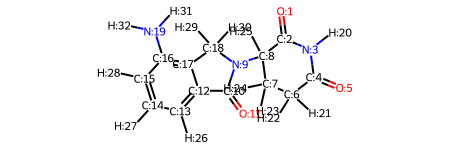

In [13]:
from rdkit.Chem import Mol as RDMol


# Adapted from https://www.rdkit.org/docs/Cookbook.html#include-an-atom-index
def mol_with_atom_index(molecule: Molecule):
    molecule_copy = Molecule(molecule)
    molecule_copy._conformers = None

    rdmol: RDMol = molecule_copy.to_rdkit()
    for atom in rdmol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx() + 1)

    return rdmol


mol_with_atom_index(molecule)

Recall that SMIRNOFF groups force field parameters into groups roughly corresponding to terms in the potential energy function. The toolkit stores these in a force field with `ParameterHandler` objects, and the corresponding data is stored in Interchange as "collections." Most, but not all, correspond 1:1 and share names.

In [14]:
for handler_name in sage.registered_parameter_handlers:
    print(handler_name, sage[handler_name])

Constraints <openff.toolkit.typing.engines.smirnoff.parameters.ConstraintHandler object at 0x14413f690>
Bonds <openff.toolkit.typing.engines.smirnoff.parameters.BondHandler object at 0x1440e7850>
Angles <openff.toolkit.typing.engines.smirnoff.parameters.AngleHandler object at 0x1440e7e50>
ProperTorsions <openff.toolkit.typing.engines.smirnoff.parameters.ProperTorsionHandler object at 0x143daf210>
ImproperTorsions <openff.toolkit.typing.engines.smirnoff.parameters.ImproperTorsionHandler object at 0x1440e7a90>
vdW <openff.toolkit.typing.engines.smirnoff.parameters.vdWHandler object at 0x1440ec2d0>
Electrostatics <openff.toolkit.typing.engines.smirnoff.parameters.ElectrostaticsHandler object at 0x1440e7550>
LibraryCharges <openff.toolkit.typing.engines.smirnoff.parameters.LibraryChargeHandler object at 0x143d7e710>
ToolkitAM1BCC <openff.toolkit.typing.engines.smirnoff.parameters.ToolkitAM1BCCHandler object at 0x143d5fe90>


Each potential handler implements a few key methods as required by the base class. These are
* `type`: A string identifying the type of stored potentials
* `expression`: An algebraic expression (or otherwise information) used to compute the potential energy from this collection
* `supported_paramters`: A sequence of strings identifying the parameters supported by this handler (i.e. `k`, `periodicity`, `phase`)
* `slot_map`: A mapping between topological locations ("slots") and unique identifiers of applied parameters
* `potentials`: A mapping between unique identifiers of applies parameters and the parameters themselves.

Each handler may also introduce more fields and methods as needed.

In [15]:
from openff.interchange.smirnoff._base import SMIRNOFFCollection

?SMIRNOFFCollection

As a simple case, let's look at the bond handler and its contents.

In [16]:
bond_collection = interchange["Bonds"]

bond_collection.type, bond_collection.expression

('Bonds', 'k/2*(r-length)**2')

In [17]:
bond_collection.fractional_bond_order_interpolation, bond_collection.fractional_bond_order_method

('linear', 'AM1-Wiberg')


<div class="alert alert-warning" style="max-width: 700px; margin-left: auto; margin-right: auto;">
    ❓ Can you find where in the <code>ForceField</code> object these value came from? Hint: you can look up a <code>ParameterHandler<code> from within a force field with square brackets, just like how you'd look up items from a dictionary in Python. (Some things might be spelled slightly differently between objects - sorry about that!)
</div>


In [18]:
bond_collection.slot_map

/var/folders/p1/176rcfkn6zlbbjq4bdjmv2pr0000gn/T/ipykernel_32065/1360661991.py:1: InterchangeDeprecationWarning: The `slot_map` attribute is deprecated. Use `key_map` instead.
  bond_collection.slot_map


{BondKey with atom indices (0, 1): PotentialKey associated with handler 'Bonds' with id '[#6:1]=[#8X1+0,#8X2+1:2]',
 BondKey with atom indices (1, 2): PotentialKey associated with handler 'Bonds' with id '[#6X3:1](=[#8X1+0])-[#7X3:2]',
 BondKey with atom indices (1, 7): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#6X3:2]=[#8X1+0]',
 BondKey with atom indices (2, 3): PotentialKey associated with handler 'Bonds' with id '[#6X3:1](=[#8X1+0])-[#7X3:2]',
 BondKey with atom indices (2, 19): PotentialKey associated with handler 'Bonds' with id '[#7:1]-[#1:2]',
 BondKey with atom indices (3, 4): PotentialKey associated with handler 'Bonds' with id '[#6:1]=[#8X1+0,#8X2+1:2]',
 BondKey with atom indices (3, 5): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#6X3:2]=[#8X1+0]',
 BondKey with atom indices (5, 6): PotentialKey associated with handler 'Bonds' with id '[#6X4:1]-[#6X4:2]',
 BondKey with atom indices (5, 20): PotentialKey associated with handler 'Bon

Let's inspect these objects one  by one, starting with the first topology key in the slot map.

In [19]:
first_topology_key = [*bond_collection.slot_map.keys()][0]

first_topology_key, type(first_topology_key)

/var/folders/p1/176rcfkn6zlbbjq4bdjmv2pr0000gn/T/ipykernel_32065/2753291394.py:1: InterchangeDeprecationWarning: The `slot_map` attribute is deprecated. Use `key_map` instead.
  first_topology_key = [*bond_collection.slot_map.keys()][0]


(BondKey with atom indices (0, 1), openff.interchange.models.BondKey)

This object stores information about where in the topology some parameter is meant to be found. In this case, that is fully specified by the indices of the two atoms in the bonds.

In [20]:
first_topology_key.atom_indices

(0, 1)

The `PotentialHandler.slot_map` maps from these keys to `PotentialKey` objects, which are unique identifiers of parameters.

In [21]:
first_potential_key = bond_collection.slot_map[first_topology_key]

first_potential_key, type(first_potential_key)

/var/folders/p1/176rcfkn6zlbbjq4bdjmv2pr0000gn/T/ipykernel_32065/719728304.py:1: InterchangeDeprecationWarning: The `slot_map` attribute is deprecated. Use `key_map` instead.
  first_potential_key = bond_collection.slot_map[first_topology_key]


(PotentialKey associated with handler 'Bonds' with id '[#6:1]=[#8X1+0,#8X2+1:2]',
 openff.interchange.models.PotentialKey)

In the case of SMIRNOFF force fields, the SMIRKS pattern uniquely identifies the parameters in a particular handler. In other typing schemes this might be an atom type or a combination of atom types.

In [22]:
first_potential_key.id, first_potential_key.associated_handler

('[#6:1]=[#8X1+0,#8X2+1:2]', 'Bonds')

Finally, `PotentialHandler` maps from these potential keys to `potential` objects themselves, allowing for parameter de-duplication and quick lookup.

In [23]:
first_potential = bond_collection.potentials[first_potential_key]

first_potential, type(first_potential)

(Potential(parameters={'k': <Quantity(1527.01974, 'kilocalorie / angstrom ** 2 / mole')>, 'length': <Quantity(1.22166864, 'angstrom')>}, map_key=None),
 openff.interchange.components.potentials.Potential)

In [24]:
first_potential.parameters

{'k': 1527.019744047 <Unit('kilocalorie / angstrom ** 2 / mole')>,
 'length': 1.221668642702 <Unit('angstrom')>}

Putting this all together, one could write a function that takes in two atom indices and returns the equilibrium bond length and then use this function to compare the parameters applied to carbon-carbon bonds in each ring and between them.

In [25]:
from openff.interchange.components.potentials import Potential
from openff.interchange.models import BondKey, PotentialKey, ProperTorsionKey


def get_k(interchange: Interchange, atom_indices: tuple[int]):
    bond_collection = interchange["Bonds"]

    topology_key: BondKey = BondKey(atom_indices=atom_indices)
    potential_key: PotentialKey = bond_collection.slot_map[topology_key]
    potential: Potential = bond_collection.potentials[potential_key]

    return potential_key.id, potential.parameters["k"]


get_k(interchange, (0, 1)), get_k(interchange, (5, 6))

/var/folders/p1/176rcfkn6zlbbjq4bdjmv2pr0000gn/T/ipykernel_32065/160123702.py:9: InterchangeDeprecationWarning: The `slot_map` attribute is deprecated. Use `key_map` instead.
  potential_key: PotentialKey = bond_collection.slot_map[topology_key]


(('[#6:1]=[#8X1+0,#8X2+1:2]',
  1527.019744047 <Unit('kilocalorie / angstrom ** 2 / mole')>),
 ('[#6X4:1]-[#6X4:2]',
  419.9869268191 <Unit('kilocalorie / angstrom ** 2 / mole')>))

More interestingly, we could modify this slightly to instead compare the force constant of in-ring and between-ring torsions. (This only reports the force constant of one phase, but these torsions each happen to be single-phase.)

In [26]:
def get_k(interchange: Interchange, atom_indices: tuple[int]):
    dihedral_handler = interchange["ProperTorsions"]

    topology_key: ProperTorsionKey = ProperTorsionKey(atom_indices=atom_indices, mult=0)
    potential_key: PotentialKey = dihedral_handler.slot_map[topology_key]
    potential: Potential = dihedral_handler.potentials[potential_key]

    return potential_key.id, potential.parameters["k"]


get_k(interchange, (0, 1, 2, 3)), get_k(interchange, (1, 7, 8, 17))

/var/folders/p1/176rcfkn6zlbbjq4bdjmv2pr0000gn/T/ipykernel_32065/691688009.py:5: InterchangeDeprecationWarning: The `slot_map` attribute is deprecated. Use `key_map` instead.
  potential_key: PotentialKey = dihedral_handler.slot_map[topology_key]


(('[*:1]-[#7X3:2]-[#6X3$(*=[#8,#16,#7]):3]~[*:4]',
  2.169667208431 <Unit('kilocalorie / mole')>),
 ('[*:1]-[#6X4:2]-[#7X3$(*~[#6X3,#6X2]):3]~[*:4]',
  0.3211560582805 <Unit('kilocalorie / mole')>))